<a href="https://colab.research.google.com/github/hyeonu96/first-repository/blob/main/%5BEX_16%5D_Segmentation_map%EC%9C%BC%EB%A1%9C_%EB%8F%84%EB%A1%9C_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EX_16 Segmentation map으로 도로 이미지 만들기

프로젝트 설명

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

1. 데이터 불러오기 및 전처리

In [ ]:
import tensorflow as tf
import numpy as np
import cv2 

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/'
train_data_path = data_path+'train/'
val_data_path = data_path+'val/'

print("number of train examples :", len(os.listdir(train_data_path)))
print("number of validation examples :", len(os.listdir(val_data_path)))

number of train examples : 1001
number of validation examples : 6


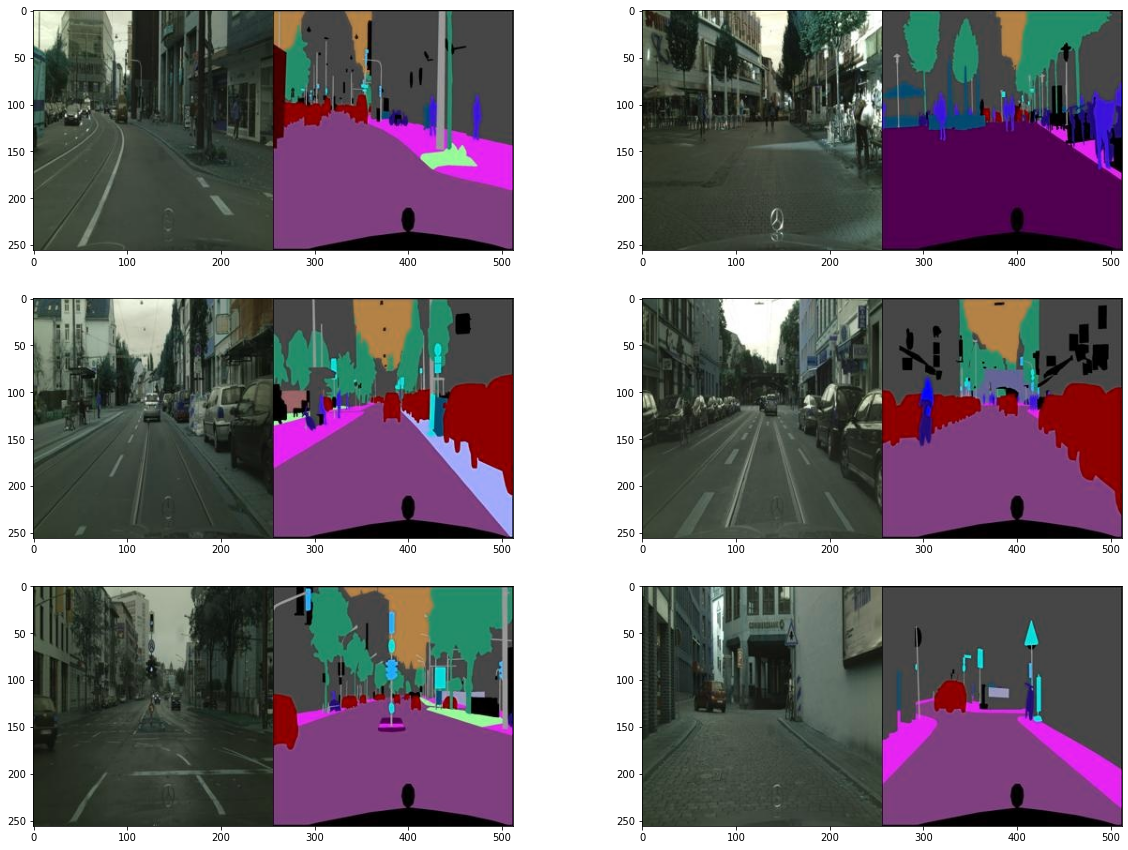

In [ ]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)



*   이미지의 크기 확인

In [ ]:
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 이미지를 2개로 나누어 사용 (가로축 기준 분할)

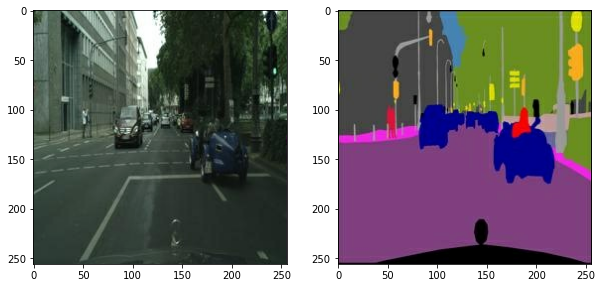

In [ ]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

- train 데이터가 1000개이기 때문에 학습을 위해 augmentation을 이용해 데이터셋을 증가

In [ ]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


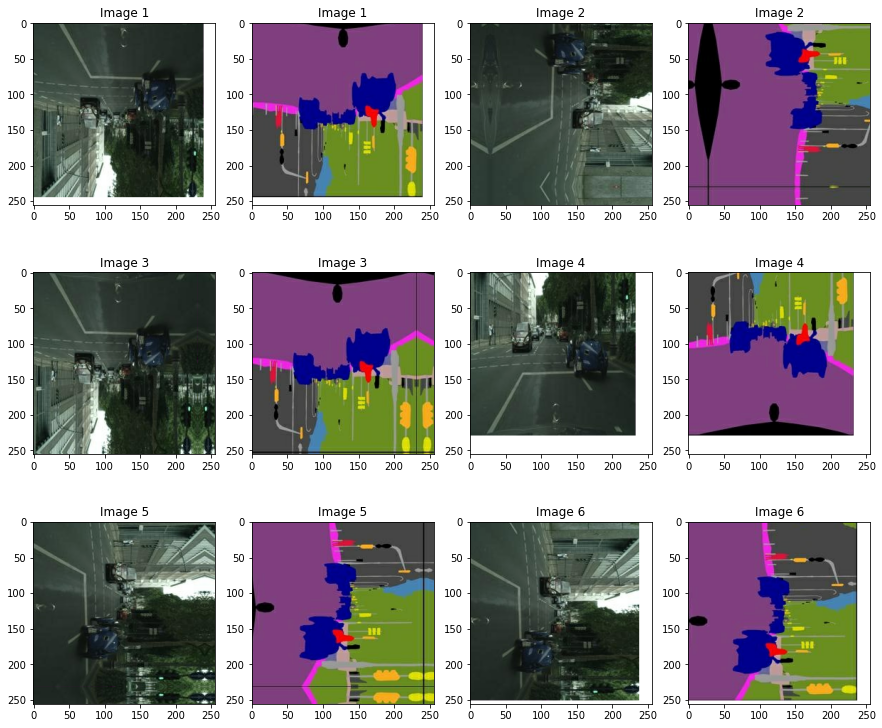

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

- 이미지 자르기, 뒤집기, 회전을 적용
- train dataset 전체에 해당 augmentation 적용

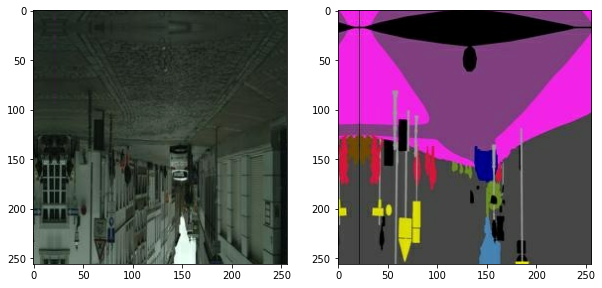

In [ ]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

2-1. Generator 구성
- Pix2Pix의 구조를 구현
- skip connection을 추가한 U-Net 구조로 구성

In [ ]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [ ]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [ ]:
Encoder().get_summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block_32 (EncodeBloc  (None, 128, 128, 64)     3072      
 k)                                                              
                                                                 
 encode_block_33 (EncodeBloc  (None, 64, 64, 128)      131584    
 k)                                                              
                                                                 
 encode_block_34 (EncodeBloc  (None, 32, 32, 256)      525312    
 k)                                                              
                                                                 
 encode_block_35 (EncodeBloc  (None, 16, 16, 512)      2099200   
 k)                                                        

In [ ]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [ ]:
Decoder().get_summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 1, 256)]       0         
                                                                 
 decode_block_28 (DecodeBloc  (None, 2, 2, 512)        2099200   
 k)                                                              
                                                                 
 decode_block_29 (DecodeBloc  (None, 4, 4, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_30 (DecodeBloc  (None, 8, 8, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_31 (DecodeBloc  (None, 16, 16, 512)      4196352   
 k)                                                        

In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [ ]:
UNetGenerator().get_summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_40 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_41 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_40[0][0]']        
                                                                                            

2-2. Discriminator 구성
- Pix2Pix의 구조를 구현

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [ ]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d_9 (ZeroPaddi  (None, 130, 130, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_69 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_103 (Ba  (None, 127, 127, 64)     256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [ ]:
Discriminator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_18 (Concatenate)   (None, 256, 256, 6)  0           ['input_11[0][0]',               
                                                                  'input_12[0][0]']         

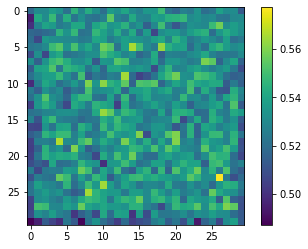

In [ ]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

3. 모델 학습

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [ ]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [ ]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_54' defined at (most recent call last):
    File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_855/369693330.py", line 8, in <module>
      g_loss, l1_loss, d_loss = train_step(sketch, colored)
    File "/tmp/ipykernel_855/4054999593.py", line 19, in train_step
      disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_54'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_54}}]] [Op:__inference_train_step_21730]

FailedPreconditionError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /aiffel/aiffel/conditional_generation/cityscapes/val/.ipynb_checkpoints; Is a directory [Op:ReadFile]

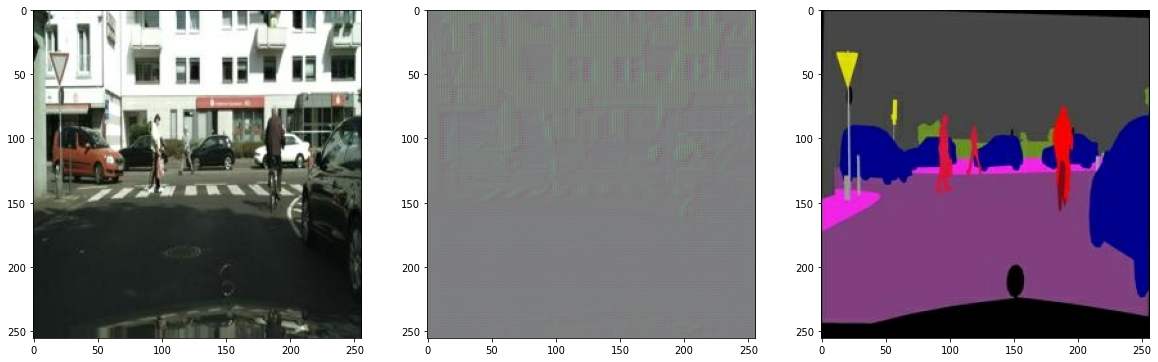

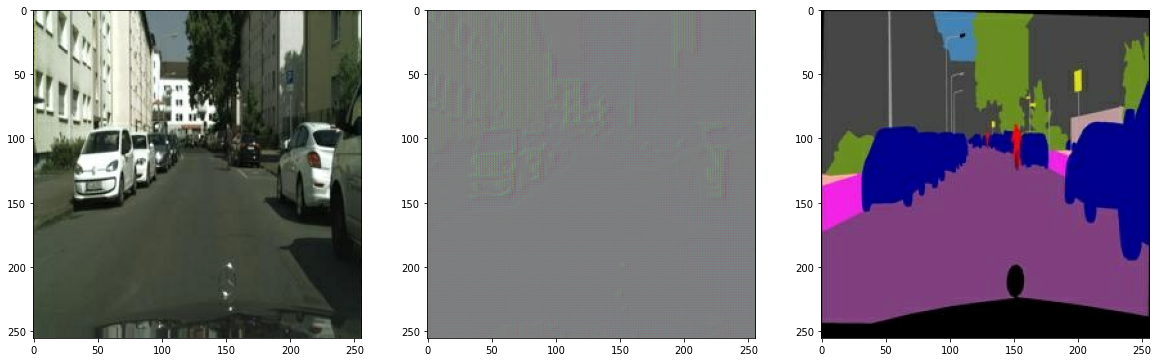

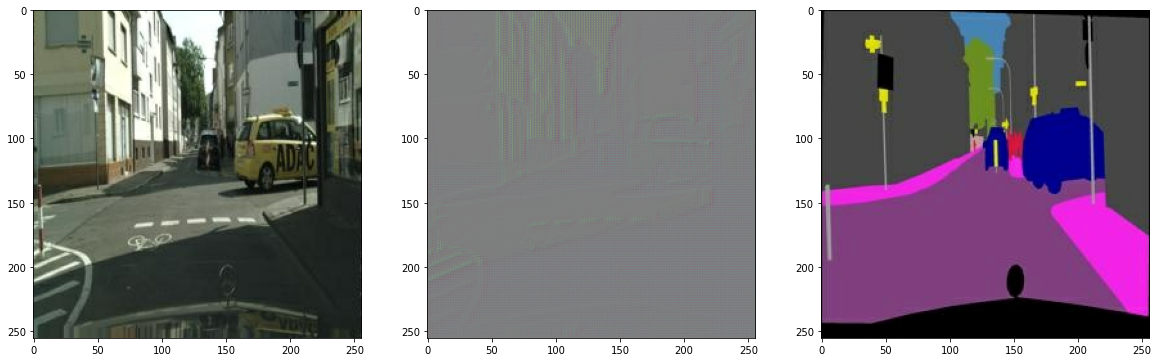

In [ ]:
test_ind = 1

for i in range(len(os.listdir(val_data_path))):
    f = val_data_path + os.listdir(val_data_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [ ]:
#LMS로 진행했을때 잘 보임
EPOCH[1] - STEP[10]                     
Generator_loss:0.8555                     
L1_loss:0.3890                     
Discriminator_loss:1.4051

EPOCH[1] - STEP[20]                     
Generator_loss:0.9256                     
L1_loss:0.3147                     
Discriminator_loss:1.2338

EPOCH[1] - STEP[30]                     
Generator_loss:1.4280                     
L1_loss:0.2811                     
Discriminator_loss:0.7557

EPOCH[1] - STEP[40]                     
Generator_loss:1.5646                     
L1_loss:0.2814                     
Discriminator_loss:0.8290

EPOCH[1] - STEP[50]                     
Generator_loss:1.8492                     
L1_loss:0.2263                     
Discriminator_loss:0.6843

EPOCH[1] - STEP[60]                     
Generator_loss:1.4985                     
L1_loss:0.2544                     
Discriminator_loss:0.6265

EPOCH[1] - STEP[70]                     
Generator_loss:2.2243                     
L1_loss:0.2163                     
Discriminator_loss:0.6127

EPOCH[1] - STEP[80]                     
Generator_loss:0.8452                     
L1_loss:0.2807                     
Discriminator_loss:1.0098

EPOCH[1] - STEP[90]                     
Generator_loss:1.8634                     
L1_loss:0.2783                     
Discriminator_loss:0.4613

EPOCH[1] - STEP[100]                     
Generator_loss:1.7875                     
L1_loss:0.2470                     
Discriminator_loss:0.5002

EPOCH[1] - STEP[110]                     
Generator_loss:2.2980                     
L1_loss:0.2615                     
Discriminator_loss:2.0456

EPOCH[1] - STEP[120]                     
Generator_loss:2.1374                     
L1_loss:0.2104                     
Discriminator_loss:0.3717

EPOCH[1] - STEP[130]                     
Generator_loss:1.1672                     
L1_loss:0.2150                     
Discriminator_loss:0.9606

EPOCH[1] - STEP[140]                     
Generator_loss:1.7474                     
L1_loss:0.2581                     
Discriminator_loss:1.3017

EPOCH[1] - STEP[150]                     
Generator_loss:1.5855                     
L1_loss:0.2620                     
Discriminator_loss:0.7162

EPOCH[1] - STEP[160]                     
Generator_loss:1.3005                     
L1_loss:0.2646                     
Discriminator_loss:0.7583

EPOCH[1] - STEP[170]                     
Generator_loss:2.1158                     
L1_loss:0.2753                     
Discriminator_loss:0.5443

EPOCH[1] - STEP[180]                     
Generator_loss:1.7048                     
L1_loss:0.2614                     
Discriminator_loss:0.5857

EPOCH[1] - STEP[190]                     
Generator_loss:2.1258                     
L1_loss:0.2360                     
Discriminator_loss:0.5462

EPOCH[1] - STEP[200]                     
Generator_loss:1.5837                     
L1_loss:0.2333                     
Discriminator_loss:0.4450

EPOCH[1] - STEP[210]                     
Generator_loss:1.9365                     
L1_loss:0.2824                     
Discriminator_loss:0.4137

EPOCH[1] - STEP[220]                     
Generator_loss:1.0561                     
L1_loss:0.2415                     
Discriminator_loss:1.2000

EPOCH[1] - STEP[230]                     
Generator_loss:1.7429                     
L1_loss:0.2332                     
Discriminator_loss:0.7315

EPOCH[1] - STEP[240]                     
Generator_loss:2.6305                     
L1_loss:0.2485                     
Discriminator_loss:0.7769

EPOCH[1] - STEP[250]                     
Generator_loss:1.0967                     
L1_loss:0.2675                     
Discriminator_loss:0.9702

EPOCH[2] - STEP[10]                     
Generator_loss:2.6825                     
L1_loss:0.2309                     
Discriminator_loss:1.1799

EPOCH[2] - STEP[20]                     
Generator_loss:0.9645                     
L1_loss:0.2132                     
Discriminator_loss:0.7659

EPOCH[2] - STEP[30]                     
Generator_loss:1.1069                     
L1_loss:0.1835                     
Discriminator_loss:0.7532

EPOCH[2] - STEP[40]                     
Generator_loss:2.1840                     
L1_loss:0.2062                     
Discriminator_loss:0.6477

EPOCH[2] - STEP[50]                     
Generator_loss:2.8922                     
L1_loss:0.1965                     
Discriminator_loss:0.9215

EPOCH[2] - STEP[60]                     
Generator_loss:2.4276                     
L1_loss:0.2709                     
Discriminator_loss:0.3493

EPOCH[2] - STEP[70]                     
Generator_loss:1.0958                     
L1_loss:0.2280                     
Discriminator_loss:0.8459

EPOCH[2] - STEP[80]                     
Generator_loss:1.3189                     
L1_loss:0.2710                     
Discriminator_loss:0.7945

EPOCH[2] - STEP[90]                     
Generator_loss:2.9697                     
L1_loss:0.2001                     
Discriminator_loss:0.7002

EPOCH[2] - STEP[100]                     
Generator_loss:0.3872                     
L1_loss:0.1935                     
Discriminator_loss:1.4358

EPOCH[2] - STEP[110]                     
Generator_loss:1.7595                     
L1_loss:0.2205                     
Discriminator_loss:0.9450

EPOCH[2] - STEP[120]                     
Generator_loss:0.8059                     
L1_loss:0.2200                     
Discriminator_loss:0.8422

EPOCH[2] - STEP[130]                     
Generator_loss:1.3056                     
L1_loss:0.1987                     
Discriminator_loss:0.8951

EPOCH[2] - STEP[140]                     
Generator_loss:4.1508                     
L1_loss:0.2340                     
Discriminator_loss:0.2173

EPOCH[2] - STEP[150]                     
Generator_loss:1.7905                     
L1_loss:0.1922                     
Discriminator_loss:0.4378

EPOCH[2] - STEP[160]                     
Generator_loss:1.9290                     
L1_loss:0.2194                     
Discriminator_loss:1.5509

EPOCH[2] - STEP[170]                     
Generator_loss:0.8000                     
L1_loss:0.2436                     
Discriminator_loss:0.7686

EPOCH[2] - STEP[180]                     
Generator_loss:1.3526                     
L1_loss:0.1991                     
Discriminator_loss:0.9480

EPOCH[2] - STEP[190]                     
Generator_loss:1.3890                     
L1_loss:0.1922                     
Discriminator_loss:0.4735

EPOCH[2] - STEP[200]                     
Generator_loss:0.5356                     
L1_loss:0.2117                     
Discriminator_loss:1.3770

EPOCH[2] - STEP[210]                     
Generator_loss:2.1313                     
L1_loss:0.1897                     
Discriminator_loss:0.2903

EPOCH[2] - STEP[220]                     
Generator_loss:1.6565                     
L1_loss:0.2187                     
Discriminator_loss:0.5473

EPOCH[2] - STEP[230]                     
Generator_loss:2.5346                     
L1_loss:0.1875                     
Discriminator_loss:0.6393

EPOCH[2] - STEP[240]                     
Generator_loss:2.6008                     
L1_loss:0.1328                     
Discriminator_loss:1.9983

EPOCH[2] - STEP[250]                     
Generator_loss:1.8156                     
L1_loss:0.2006                     
Discriminator_loss:0.4095

EPOCH[3] - STEP[10]                     
Generator_loss:1.2814                     
L1_loss:0.2414                     
Discriminator_loss:0.7227

EPOCH[3] - STEP[20]                     
Generator_loss:1.7617                     
L1_loss:0.2199                     
Discriminator_loss:1.2761

EPOCH[3] - STEP[30]                     
Generator_loss:1.0094                     
L1_loss:0.1700                     
Discriminator_loss:1.5083

EPOCH[3] - STEP[40]                     
Generator_loss:2.1671                     
L1_loss:0.2237                     
Discriminator_loss:0.2580

EPOCH[3] - STEP[50]                     
Generator_loss:0.8708                     
L1_loss:0.2043                     
Discriminator_loss:1.1353

EPOCH[3] - STEP[60]                     
Generator_loss:3.4904                     
L1_loss:0.2081                     
Discriminator_loss:0.3511

EPOCH[3] - STEP[70]                     
Generator_loss:1.8550                     
L1_loss:0.1496                     
Discriminator_loss:0.8394

EPOCH[3] - STEP[80]                     
Generator_loss:1.0838                     
L1_loss:0.1890                     
Discriminator_loss:0.8110

EPOCH[3] - STEP[90]                     
Generator_loss:1.1687                     
L1_loss:0.2252                     
Discriminator_loss:0.6854

EPOCH[3] - STEP[100]                     
Generator_loss:2.1201                     
L1_loss:0.2002                     
Discriminator_loss:1.3962

EPOCH[3] - STEP[110]                     
Generator_loss:1.4303                     
L1_loss:0.1818                     
Discriminator_loss:0.5928

EPOCH[3] - STEP[120]                     
Generator_loss:1.5647                     
L1_loss:0.1852                     
Discriminator_loss:0.9963

EPOCH[3] - STEP[130]                     
Generator_loss:2.3780                     
L1_loss:0.2242                     
Discriminator_loss:0.4011

EPOCH[3] - STEP[140]                     
Generator_loss:2.4631                     
L1_loss:0.1813                     
Discriminator_loss:0.3619

EPOCH[3] - STEP[150]                     
Generator_loss:2.5415                     
L1_loss:0.2149                     
Discriminator_loss:0.3456

EPOCH[3] - STEP[160]                     
Generator_loss:2.2454                     
L1_loss:0.1758                     
Discriminator_loss:0.6791

EPOCH[3] - STEP[170]                     
Generator_loss:1.0885                     
L1_loss:0.1997                     
Discriminator_loss:0.7764

EPOCH[3] - STEP[180]                     
Generator_loss:2.7336                     
L1_loss:0.1934                     
Discriminator_loss:0.3704

EPOCH[3] - STEP[190]                     
Generator_loss:1.9411                     
L1_loss:0.2133                     
Discriminator_loss:0.3404

EPOCH[3] - STEP[200]                     
Generator_loss:1.2863                     
L1_loss:0.1749                     
Discriminator_loss:1.3139

EPOCH[3] - STEP[210]                     
Generator_loss:2.2005                     
L1_loss:0.1966                     
Discriminator_loss:0.8619

EPOCH[3] - STEP[220]                     
Generator_loss:2.7034                     
L1_loss:0.1587                     
Discriminator_loss:1.9398

EPOCH[3] - STEP[230]                     
Generator_loss:1.5544                     
L1_loss:0.2150                     
Discriminator_loss:0.5258

EPOCH[3] - STEP[240]                     
Generator_loss:1.3290                     
L1_loss:0.2038                     
Discriminator_loss:0.6703

EPOCH[3] - STEP[250]                     
Generator_loss:1.9601                     
L1_loss:0.2213                     
Discriminator_loss:0.2986

EPOCH[4] - STEP[10]                     
Generator_loss:2.9347                     
L1_loss:0.2188                     
Discriminator_loss:0.5592

EPOCH[4] - STEP[20]                     
Generator_loss:2.3344                     
L1_loss:0.2145                     
Discriminator_loss:0.7386

EPOCH[4] - STEP[30]                     
Generator_loss:1.3774                     
L1_loss:0.2009                     
Discriminator_loss:0.6625

EPOCH[4] - STEP[40]                     
Generator_loss:0.3368                     
L1_loss:0.1864                     
Discriminator_loss:1.8275

EPOCH[4] - STEP[50]                     
Generator_loss:1.3167                     
L1_loss:0.1741                     
Discriminator_loss:1.0147

EPOCH[4] - STEP[60]                     
Generator_loss:0.3549                     
L1_loss:0.1877                     
Discriminator_loss:1.7414

EPOCH[4] - STEP[70]                     
Generator_loss:1.6034                     
L1_loss:0.1911                     
Discriminator_loss:0.6201

EPOCH[4] - STEP[80]                     
Generator_loss:0.7132                     
L1_loss:0.2124                     
Discriminator_loss:1.1099

EPOCH[4] - STEP[90]                     
Generator_loss:1.6398                     
L1_loss:0.2175                     
Discriminator_loss:0.6117

EPOCH[4] - STEP[100]                     
Generator_loss:0.5916                     
L1_loss:0.1612                     
Discriminator_loss:1.0917

EPOCH[4] - STEP[110]                     
Generator_loss:1.5139                     
L1_loss:0.1922                     
Discriminator_loss:0.5189

EPOCH[4] - STEP[120]                     
Generator_loss:1.8079                     
L1_loss:0.1919                     
Discriminator_loss:0.8158

EPOCH[4] - STEP[130]                     
Generator_loss:3.3871                     
L1_loss:0.1711                     
Discriminator_loss:1.3538

EPOCH[4] - STEP[140]                     
Generator_loss:1.0465                     
L1_loss:0.1896                     
Discriminator_loss:1.1337

EPOCH[4] - STEP[150]                     
Generator_loss:1.3777                     
L1_loss:0.2039                     
Discriminator_loss:1.1742

EPOCH[4] - STEP[160]                     
Generator_loss:1.8373                     
L1_loss:0.2287                     
Discriminator_loss:0.8424

EPOCH[4] - STEP[170]                     
Generator_loss:1.5234                     
L1_loss:0.1946                     
Discriminator_loss:0.7876

EPOCH[4] - STEP[180]                     
Generator_loss:0.8932                     
L1_loss:0.1976                     
Discriminator_loss:0.7927

EPOCH[4] - STEP[190]                     
Generator_loss:3.2810                     
L1_loss:0.1678                     
Discriminator_loss:2.1396

EPOCH[4] - STEP[200]                     
Generator_loss:1.6527                     
L1_loss:0.2160                     
Discriminator_loss:0.4233

EPOCH[4] - STEP[210]                     
Generator_loss:2.4219                     
L1_loss:0.1501                     
Discriminator_loss:2.3032

EPOCH[4] - STEP[220]                     
Generator_loss:1.9279                     
L1_loss:0.1555                     
Discriminator_loss:0.5579

EPOCH[4] - STEP[230]                     
Generator_loss:1.0912                     
L1_loss:0.2293                     
Discriminator_loss:0.6218

EPOCH[4] - STEP[240]                     
Generator_loss:2.1518                     
L1_loss:0.2196                     
Discriminator_loss:0.6123

EPOCH[4] - STEP[250]                     
Generator_loss:1.2075                     
L1_loss:0.2507                     
Discriminator_loss:0.5250

EPOCH[5] - STEP[10]                     
Generator_loss:1.2137                     
L1_loss:0.2058                     
Discriminator_loss:0.5367

EPOCH[5] - STEP[20]                     
Generator_loss:2.4275                     
L1_loss:0.1638                     
Discriminator_loss:1.8395

EPOCH[5] - STEP[30]                     
Generator_loss:1.1857                     
L1_loss:0.2143                     
Discriminator_loss:0.7179

EPOCH[5] - STEP[40]                     
Generator_loss:0.5912                     
L1_loss:0.1917                     
Discriminator_loss:1.1454

EPOCH[5] - STEP[50]                     
Generator_loss:1.5713                     
L1_loss:0.1908                     
Discriminator_loss:0.8121

EPOCH[5] - STEP[60]                     
Generator_loss:1.5100                     
L1_loss:0.1821                     
Discriminator_loss:0.4833

EPOCH[5] - STEP[70]                     
Generator_loss:1.7054                     
L1_loss:0.1798                     
Discriminator_loss:1.2266

EPOCH[5] - STEP[80]                     
Generator_loss:1.3731                     
L1_loss:0.1762                     
Discriminator_loss:0.6388

EPOCH[5] - STEP[90]                     
Generator_loss:2.0842                     
L1_loss:0.1589                     
Discriminator_loss:0.9159

EPOCH[5] - STEP[100]                     
Generator_loss:3.2511                     
L1_loss:0.2565                     
Discriminator_loss:1.3634

EPOCH[5] - STEP[110]                     
Generator_loss:0.2534                     
L1_loss:0.2200                     
Discriminator_loss:1.8589

EPOCH[5] - STEP[120]                     
Generator_loss:2.2719                     
L1_loss:0.1519                     
Discriminator_loss:1.1902

EPOCH[5] - STEP[130]                     
Generator_loss:0.8333                     
L1_loss:0.1954                     
Discriminator_loss:0.8836

EPOCH[5] - STEP[140]                     
Generator_loss:1.3322                     
L1_loss:0.1735                     
Discriminator_loss:0.4722

EPOCH[5] - STEP[150]                     
Generator_loss:2.9204                     
L1_loss:0.2042                     
Discriminator_loss:0.6451

EPOCH[5] - STEP[160]                     
Generator_loss:1.6389                     
L1_loss:0.2262                     
Discriminator_loss:0.3868

EPOCH[5] - STEP[170]                     
Generator_loss:1.2315                     
L1_loss:0.2245                     
Discriminator_loss:1.6523

EPOCH[5] - STEP[180]                     
Generator_loss:1.1899                     
L1_loss:0.2005                     
Discriminator_loss:0.7774

EPOCH[5] - STEP[190]                     
Generator_loss:1.6478                     
L1_loss:0.2010                     
Discriminator_loss:0.6617

EPOCH[5] - STEP[200]                     
Generator_loss:1.1446                     
L1_loss:0.2194                     
Discriminator_loss:0.8518

EPOCH[5] - STEP[210]                     
Generator_loss:2.5651                     
L1_loss:0.1996                     
Discriminator_loss:0.4040

EPOCH[5] - STEP[220]                     
Generator_loss:1.4242                     
L1_loss:0.1813                     
Discriminator_loss:0.7481

EPOCH[5] - STEP[230]                     
Generator_loss:1.9847                     
L1_loss:0.2004                     
Discriminator_loss:0.4058

EPOCH[5] - STEP[240]                     
Generator_loss:1.1113                     
L1_loss:0.1769                     
Discriminator_loss:0.9052

EPOCH[5] - STEP[250]                     
Generator_loss:2.6906                     
L1_loss:0.1954                     
Discriminator_loss:0.6047

EPOCH[6] - STEP[10]                     
Generator_loss:0.8793                     
L1_loss:0.2247                     
Discriminator_loss:0.9422

EPOCH[6] - STEP[20]                     
Generator_loss:3.0224                     
L1_loss:0.1693                     
Discriminator_loss:1.2225

EPOCH[6] - STEP[30]                     
Generator_loss:1.2749                     
L1_loss:0.1720                     
Discriminator_loss:0.5628

EPOCH[6] - STEP[40]                     
Generator_loss:0.8897                     
L1_loss:0.2094                     
Discriminator_loss:0.9191

EPOCH[6] - STEP[50]                     
Generator_loss:0.9404                     
L1_loss:0.2014                     
Discriminator_loss:1.3490

EPOCH[6] - STEP[60]                     
Generator_loss:0.9862                     
L1_loss:0.1702                     
Discriminator_loss:1.5279

EPOCH[6] - STEP[70]                     
Generator_loss:0.8270                     
L1_loss:0.1664                     
Discriminator_loss:0.8598

EPOCH[6] - STEP[80]                     
Generator_loss:1.9008                     
L1_loss:0.1565                     
Discriminator_loss:0.6351

EPOCH[6] - STEP[90]                     
Generator_loss:1.9088                     
L1_loss:0.1949                     
Discriminator_loss:0.6715

EPOCH[6] - STEP[100]                     
Generator_loss:1.9460                     
L1_loss:0.1902                     
Discriminator_loss:0.2714

EPOCH[6] - STEP[110]                     
Generator_loss:1.7284                     
L1_loss:0.1953                     
Discriminator_loss:0.4624

EPOCH[6] - STEP[120]                     
Generator_loss:2.1675                     
L1_loss:0.1887                     
Discriminator_loss:0.6269

EPOCH[6] - STEP[130]                     
Generator_loss:2.2302                     
L1_loss:0.1783                     
Discriminator_loss:1.0800

EPOCH[6] - STEP[140]                     
Generator_loss:1.6604                     
L1_loss:0.2016                     
Discriminator_loss:0.6184

EPOCH[6] - STEP[150]                     
Generator_loss:1.1357                     
L1_loss:0.1816                     
Discriminator_loss:0.5658

EPOCH[6] - STEP[160]                     
Generator_loss:1.6396                     
L1_loss:0.1719                     
Discriminator_loss:0.7362

EPOCH[6] - STEP[170]                     
Generator_loss:1.9052                     
L1_loss:0.1627                     
Discriminator_loss:0.6264

EPOCH[6] - STEP[180]                     
Generator_loss:1.1057                     
L1_loss:0.2061                     
Discriminator_loss:0.9675

EPOCH[6] - STEP[190]                     
Generator_loss:2.6343                     
L1_loss:0.2252                     
Discriminator_loss:1.2291

EPOCH[6] - STEP[200]                     
Generator_loss:2.3793                     
L1_loss:0.1998                     
Discriminator_loss:0.7773

EPOCH[6] - STEP[210]                     
Generator_loss:1.2854                     
L1_loss:0.2362                     
Discriminator_loss:0.5266

EPOCH[6] - STEP[220]                     
Generator_loss:1.0274                     
L1_loss:0.1869                     
Discriminator_loss:0.6760

EPOCH[6] - STEP[230]                     
Generator_loss:2.3817                     
L1_loss:0.1986                     
Discriminator_loss:0.3424

EPOCH[6] - STEP[240]                     
Generator_loss:0.9894                     
L1_loss:0.2061                     
Discriminator_loss:1.1164

EPOCH[6] - STEP[250]                     
Generator_loss:1.8723                     
L1_loss:0.2077                     
Discriminator_loss:0.4672

EPOCH[7] - STEP[10]                     
Generator_loss:0.8869                     
L1_loss:0.1941                     
Discriminator_loss:0.7498

EPOCH[7] - STEP[20]                     
Generator_loss:2.0878                     
L1_loss:0.1768                     
Discriminator_loss:0.4980

EPOCH[7] - STEP[30]                     
Generator_loss:1.8419                     
L1_loss:0.1737                     
Discriminator_loss:0.3739

EPOCH[7] - STEP[40]                     
Generator_loss:2.0668                     
L1_loss:0.1591                     
Discriminator_loss:0.5269

EPOCH[7] - STEP[50]                     
Generator_loss:3.1108                     
L1_loss:0.1647                     
Discriminator_loss:0.8278

EPOCH[7] - STEP[60]                     
Generator_loss:1.3167                     
L1_loss:0.2281                     
Discriminator_loss:0.5408

EPOCH[7] - STEP[70]                     
Generator_loss:1.2989                     
L1_loss:0.2217                     
Discriminator_loss:0.6468

EPOCH[7] - STEP[80]                     
Generator_loss:0.6839                     
L1_loss:0.1835                     
Discriminator_loss:1.2050

EPOCH[7] - STEP[90]                     
Generator_loss:1.6212                     
L1_loss:0.2243                     
Discriminator_loss:0.4456

EPOCH[7] - STEP[100]                     
Generator_loss:1.9673                     
L1_loss:0.2199                     
Discriminator_loss:0.6217

EPOCH[7] - STEP[110]                     
Generator_loss:1.2414                     
L1_loss:0.1931                     
Discriminator_loss:0.5179

EPOCH[7] - STEP[120]                     
Generator_loss:1.7373                     
L1_loss:0.1789                     
Discriminator_loss:0.8769

EPOCH[7] - STEP[130]                     
Generator_loss:2.6097                     
L1_loss:0.1691                     
Discriminator_loss:1.1101

EPOCH[7] - STEP[140]                     
Generator_loss:3.0045                     
L1_loss:0.1983                     
Discriminator_loss:0.2521

EPOCH[7] - STEP[150]                     
Generator_loss:2.0645                     
L1_loss:0.1652                     
Discriminator_loss:1.0756

EPOCH[7] - STEP[160]                     
Generator_loss:1.5316                     
L1_loss:0.1570                     
Discriminator_loss:1.0726

EPOCH[7] - STEP[170]                     
Generator_loss:1.1638                     
L1_loss:0.2048                     
Discriminator_loss:0.5014

EPOCH[7] - STEP[180]                     
Generator_loss:2.7828                     
L1_loss:0.1792                     
Discriminator_loss:2.1305

EPOCH[7] - STEP[190]                     
Generator_loss:3.0688                     
L1_loss:0.1770                     
Discriminator_loss:0.7670

EPOCH[7] - STEP[200]                     
Generator_loss:2.2103                     
L1_loss:0.1645                     
Discriminator_loss:0.5805

EPOCH[7] - STEP[210]                     
Generator_loss:2.3751                     
L1_loss:0.1848                     
Discriminator_loss:1.1914

EPOCH[7] - STEP[220]                     
Generator_loss:2.2272                     
L1_loss:0.1747                     
Discriminator_loss:1.2069

EPOCH[7] - STEP[230]                     
Generator_loss:0.9126                     
L1_loss:0.1551                     
Discriminator_loss:1.0301

EPOCH[7] - STEP[240]                     
Generator_loss:2.1629                     
L1_loss:0.1719                     
Discriminator_loss:0.6647

EPOCH[7] - STEP[250]                     
Generator_loss:1.8160                     
L1_loss:0.2196                     
Discriminator_loss:0.5410

EPOCH[8] - STEP[10]                     
Generator_loss:2.5097                     
L1_loss:0.1721                     
Discriminator_loss:0.6819

EPOCH[8] - STEP[20]                     
Generator_loss:1.3102                     
L1_loss:0.1793                     
Discriminator_loss:1.2094

EPOCH[8] - STEP[30]                     
Generator_loss:2.8453                     
L1_loss:0.1754                     
Discriminator_loss:0.5832

EPOCH[8] - STEP[40]                     
Generator_loss:0.6488                     
L1_loss:0.1994                     
Discriminator_loss:0.9508

EPOCH[8] - STEP[50]                     
Generator_loss:1.0897                     
L1_loss:0.1458                     
Discriminator_loss:0.6836

EPOCH[8] - STEP[60]                     
Generator_loss:1.1916                     
L1_loss:0.1950                     
Discriminator_loss:0.7158

EPOCH[8] - STEP[70]                     
Generator_loss:0.9161                     
L1_loss:0.1679                     
Discriminator_loss:0.8997

EPOCH[8] - STEP[80]                     
Generator_loss:2.2621                     
L1_loss:0.1770                     
Discriminator_loss:0.6459

EPOCH[8] - STEP[90]                     
Generator_loss:0.8110                     
L1_loss:0.1750                     
Discriminator_loss:0.9325

EPOCH[8] - STEP[100]                     
Generator_loss:1.0885                     
L1_loss:0.2159                     
Discriminator_loss:0.8154

EPOCH[8] - STEP[110]                     
Generator_loss:1.2734                     
L1_loss:0.1840                     
Discriminator_loss:0.5494

EPOCH[8] - STEP[120]                     
Generator_loss:2.6282                     
L1_loss:0.1948                     
Discriminator_loss:0.7093

EPOCH[8] - STEP[130]                     
Generator_loss:1.4329                     
L1_loss:0.2443                     
Discriminator_loss:0.5844

EPOCH[8] - STEP[140]                     
Generator_loss:2.6418                     
L1_loss:0.1770                     
Discriminator_loss:0.6369

EPOCH[8] - STEP[150]                     
Generator_loss:2.5727                     
L1_loss:0.1855                     
Discriminator_loss:0.5456

EPOCH[8] - STEP[160]                     
Generator_loss:1.2392                     
L1_loss:0.1719                     
Discriminator_loss:0.5720

EPOCH[8] - STEP[170]                     
Generator_loss:1.5645                     
L1_loss:0.2054                     
Discriminator_loss:0.7010

EPOCH[8] - STEP[180]                     
Generator_loss:1.9831                     
L1_loss:0.1465                     
Discriminator_loss:0.5739

EPOCH[8] - STEP[190]                     
Generator_loss:1.0456                     
L1_loss:0.1882                     
Discriminator_loss:0.5521

EPOCH[8] - STEP[200]                     
Generator_loss:1.4647                     
L1_loss:0.1976                     
Discriminator_loss:0.4678

EPOCH[8] - STEP[210]                     
Generator_loss:1.3776                     
L1_loss:0.1550                     
Discriminator_loss:1.6461

EPOCH[8] - STEP[220]                     
Generator_loss:1.3682                     
L1_loss:0.1628                     
Discriminator_loss:0.5187

EPOCH[8] - STEP[230]                     
Generator_loss:1.5945                     
L1_loss:0.1483                     
Discriminator_loss:0.5499

EPOCH[8] - STEP[240]                     
Generator_loss:0.9933                     
L1_loss:0.1755                     
Discriminator_loss:0.9224

EPOCH[8] - STEP[250]                     
Generator_loss:0.8716                     
L1_loss:0.1551                     
Discriminator_loss:0.8369

EPOCH[9] - STEP[10]                     
Generator_loss:1.6620                     
L1_loss:0.1548                     
Discriminator_loss:1.3562

EPOCH[9] - STEP[20]                     
Generator_loss:1.5449                     
L1_loss:0.2181                     
Discriminator_loss:0.4558

EPOCH[9] - STEP[30]                     
Generator_loss:1.9597                     
L1_loss:0.1905                     
Discriminator_loss:0.3181

EPOCH[9] - STEP[40]                     
Generator_loss:1.6502                     
L1_loss:0.1746                     
Discriminator_loss:0.6156

EPOCH[9] - STEP[50]                     
Generator_loss:1.9940                     
L1_loss:0.1743                     
Discriminator_loss:0.5613

EPOCH[9] - STEP[60]                     
Generator_loss:1.6907                     
L1_loss:0.1848                     
Discriminator_loss:0.3713

EPOCH[9] - STEP[70]                     
Generator_loss:1.8321                     
L1_loss:0.1870                     
Discriminator_loss:0.6000

EPOCH[9] - STEP[80]                     
Generator_loss:1.6932                     
L1_loss:0.1669                     
Discriminator_loss:0.5780

EPOCH[9] - STEP[90]                     
Generator_loss:1.3069                     
L1_loss:0.1320                     
Discriminator_loss:1.2979

EPOCH[9] - STEP[100]                     
Generator_loss:1.8885                     
L1_loss:0.2120                     
Discriminator_loss:0.4042

EPOCH[9] - STEP[110]                     
Generator_loss:1.6413                     
L1_loss:0.2132                     
Discriminator_loss:2.3785

EPOCH[9] - STEP[120]                     
Generator_loss:1.8423                     
L1_loss:0.1606                     
Discriminator_loss:0.3622

EPOCH[9] - STEP[130]                     
Generator_loss:1.4533                     
L1_loss:0.2008                     
Discriminator_loss:0.5457

EPOCH[9] - STEP[140]                     
Generator_loss:1.9710                     
L1_loss:0.1754                     
Discriminator_loss:1.3608

EPOCH[9] - STEP[150]                     
Generator_loss:1.5730                     
L1_loss:0.2072                     
Discriminator_loss:0.3929

EPOCH[9] - STEP[160]                     
Generator_loss:2.2966                     
L1_loss:0.1890                     
Discriminator_loss:0.3966

EPOCH[9] - STEP[170]                     
Generator_loss:1.6586                     
L1_loss:0.1737                     
Discriminator_loss:0.7390

EPOCH[9] - STEP[180]                     
Generator_loss:1.4487                     
L1_loss:0.1716                     
Discriminator_loss:0.9035

EPOCH[9] - STEP[190]                     
Generator_loss:0.7567                     
L1_loss:0.1957                     
Discriminator_loss:1.0052

EPOCH[9] - STEP[200]                     
Generator_loss:2.3818                     
L1_loss:0.1760                     
Discriminator_loss:1.8022

EPOCH[9] - STEP[210]                     
Generator_loss:1.2145                     
L1_loss:0.1551                     
Discriminator_loss:0.8979

EPOCH[9] - STEP[220]                     
Generator_loss:1.3365                     
L1_loss:0.1543                     
Discriminator_loss:1.0254

EPOCH[9] - STEP[230]                     
Generator_loss:0.7979                     
L1_loss:0.2030                     
Discriminator_loss:0.9477

EPOCH[9] - STEP[240]                     
Generator_loss:2.0866                     
L1_loss:0.1716                     
Discriminator_loss:1.2830

EPOCH[9] - STEP[250]                     
Generator_loss:1.5329                     
L1_loss:0.1462                     
Discriminator_loss:0.5126

EPOCH[10] - STEP[10]                     
Generator_loss:1.7557                     
L1_loss:0.1686                     
Discriminator_loss:0.7822

EPOCH[10] - STEP[20]                     
Generator_loss:1.1476                     
L1_loss:0.1795                     
Discriminator_loss:0.7574

EPOCH[10] - STEP[30]                     
Generator_loss:1.9905                     
L1_loss:0.2017                     
Discriminator_loss:0.5681

EPOCH[10] - STEP[40]                     
Generator_loss:1.3216                     
L1_loss:0.1612                     
Discriminator_loss:0.8116

EPOCH[10] - STEP[50]                     
Generator_loss:2.1723                     
L1_loss:0.1540                     
Discriminator_loss:0.3746

EPOCH[10] - STEP[60]                     
Generator_loss:2.3021                     
L1_loss:0.1727                     
Discriminator_loss:1.4682

EPOCH[10] - STEP[70]                     
Generator_loss:2.3611                     
L1_loss:0.1586                     
Discriminator_loss:0.8080

EPOCH[10] - STEP[80]                     
Generator_loss:2.4434                     
L1_loss:0.1721                     
Discriminator_loss:0.2870

EPOCH[10] - STEP[90]                     
Generator_loss:2.1983                     
L1_loss:0.1382                     
Discriminator_loss:0.9200

EPOCH[10] - STEP[100]                     
Generator_loss:1.6872                     
L1_loss:0.2107                     
Discriminator_loss:0.3830

EPOCH[10] - STEP[110]                     
Generator_loss:2.7458                     
L1_loss:0.1881                     
Discriminator_loss:0.8426

EPOCH[10] - STEP[120]                     
Generator_loss:1.3416                     
L1_loss:0.2058                     
Discriminator_loss:1.7831

EPOCH[10] - STEP[130]                     
Generator_loss:2.0852                     
L1_loss:0.1840                     
Discriminator_loss:0.2638

EPOCH[10] - STEP[140]                     
Generator_loss:2.6687                     
L1_loss:0.1583                     
Discriminator_loss:0.9182

EPOCH[10] - STEP[150]                     
Generator_loss:1.3888                     
L1_loss:0.1765                     
Discriminator_loss:1.2159

EPOCH[10] - STEP[160]                     
Generator_loss:1.3488                     
L1_loss:0.1955                     
Discriminator_loss:0.5729

EPOCH[10] - STEP[170]                     
Generator_loss:1.6116                     
L1_loss:0.1655                     
Discriminator_loss:0.5420

EPOCH[10] - STEP[180]                     
Generator_loss:1.7623                     
L1_loss:0.1660                     
Discriminator_loss:0.6085

EPOCH[10] - STEP[190]                     
Generator_loss:2.1521                     
L1_loss:0.2129                     
Discriminator_loss:0.4013

EPOCH[10] - STEP[200]                     
Generator_loss:1.1152                     
L1_loss:0.1888                     
Discriminator_loss:0.5144

EPOCH[10] - STEP[210]                     
Generator_loss:0.3699                     
L1_loss:0.1610                     
Discriminator_loss:1.9150

EPOCH[10] - STEP[220]                     
Generator_loss:1.7342                     
L1_loss:0.2039                     
Discriminator_loss:0.3423

EPOCH[10] - STEP[230]                     
Generator_loss:1.7138                     
L1_loss:0.1371                     
Discriminator_loss:1.1296

EPOCH[10] - STEP[240]                     
Generator_loss:2.0800                     
L1_loss:0.1518                     
Discriminator_loss:0.8330

EPOCH[10] - STEP[250]                     
Generator_loss:1.4426                     
L1_loss:0.1766                     
Discriminator_loss:1.7658

In [ ]:
#아래 코드도 결과가 잘나왔지만 주피터에서 잘안나옴
<matplotlib.image.AxesImage at 0x7fc8244a3df0>


루브릭 평가

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.

- 자르기, 뒤집기, 회전을 적용해 데이터셋을 구축했다.

2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.

- U-Net generator와 discriminator 모델을 구현하였고, train_step은 안정적으로 진행되었다.

3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.

- 10 epochs를 학습했고, 도로에 대한 segmentation이 어느정도 잘 생성되었다.
5장의 validation 이미지를 시각화해 결과를 확인했다.

회고

pix2pix 모델을 사용하여 이미지를 만들어 보았다. 위 epoch 코드와 test 코드를 보면 에러가 발생하였는데, LMS를 통해 코드를 진행시켜보니 아무 문제 없이 코드가 돌아가는 것을 보았다. 에러가 발생했지만 어떠한 프로그램을 통해 돌리냐에 따라 에러의 발생 여부가 다른것 같다. 에러를 해결하기 위한 구글링 또한 통하지 않아 어려웠다.
 코드를 보았을때 epoch를 천단위 혹은 만단위까지 올려야 원하고자 하는 선명한 데이터를 얻을 수 있을 것 같다.

